# 🧪 Micro Rep Template: MMM MVP

## 🔧 Step 1: Simulate the Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# simulate MMM data, 3 channels (tv paid search, social media), 52 weeks
np.random.seed(42)

n_weeks = 52
date_range = pd.date_range(start='2025-01-01', periods=n_weeks, freq='W')
tv_spend = np.random.uniform(1000, 5000, n_weeks)
search_spend = np.random.uniform(500, 3000, n_weeks)
social_spend = np.random.uniform(200, 1500, n_weeks)
randomness = np.random.normal(0, 200, n_weeks)
sales = (0.05 * tv_spend + 0.1 * search_spend + 0.08 * social_spend + randomness).clip(min=0)
data = pd.DataFrame({
    'date': date_range,
    'tv_spend': tv_spend,
    'search_spend': search_spend,
    'social_spend': social_spend,
    'sales': sales
})
data = data.set_index('date')
data.head()

,tv_spend,search_spend,social_spend,sales
date,,,,
2025-01-05,2498.160475,2848.747354,1379.836416,748.734235
2025-01-12,4802.857226,2737.068376,524.079898,706.162697
2025-01-19,3927.975767,1994.749947,733.497800,612.759996
2025-01-26,3394.633937,2804.685588,1182.216480,362.900083
2025-02-02,1624.074562,721.231255,497.437615,473.680725


In [3]:
# Adstock = delayed media impact over time

# Let's add some adstock effects
def geometric_adstock(spend, alpha):
    """Apply geometric adstock to a spend vector."""
    adstocked = np.zeros_like(spend)
    for t in range(len(spend)):
        if t == 0:
            adstocked[t] = spend[t]
        else:
            adstocked[t] = spend[t] + alpha * adstocked[t - 1]
    return adstocked


# TV has high carryover (α = 0.6)

# Search is short-term (α = 0.3)

# Social is in-between (α = 0.4)

data['tv_adstock'] = geometric_adstock(data['tv_spend'].values, 0.6)
data['search_adstock'] = geometric_adstock(data['search_spend'].values, 0.3)
data['social_adstock'] = geometric_adstock(data['social_spend'].values, 0.4)

In [4]:
# Final sales
data['sales_adstock'] = (
    2000 +                    # Base sales level
    500 * data['tv_adstock'] +         # TV has a bigger effect
    400 * data['search_adstock'] +
    300 * data['social_adstock'] +
    np.random.normal(0, 300, n_weeks)
)
data.head()

,tv_spend,search_spend,social_spend,sales,tv_adstock,search_adstock,social_adstock,sales_adstock
date,,,,,,,,
2025-01-05,2498.160475,2848.747354,1379.836416,748.734235,2498.160475,2848.747354,1379.836416,2.804263e+06
2025-01-12,4802.857226,2737.068376,524.079898,706.162697,6301.753511,3591.692582,1076.014464,4.912113e+06
2025-01-19,3927.975767,1994.749947,733.497800,612.759996,7709.027874,3072.257722,1163.903586,5.434565e+06
2025-01-26,3394.633937,2804.685588,1182.216480,362.900083,8020.050661,3726.362904,1647.777914,5.997006e+06
2025-02-02,1624.074562,721.231255,497.437615,473.680725,6436.104958,1839.140126,1156.548781,4.302756e+06


## 📦 Step 2: Data Prep

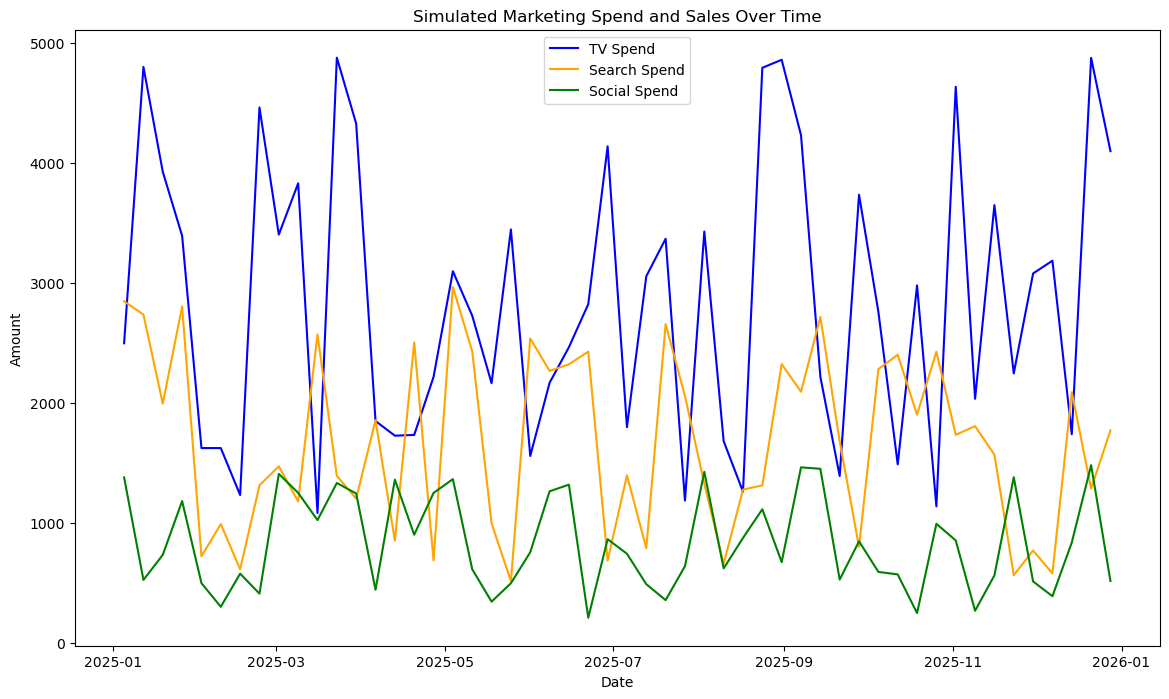

In [5]:
# visualize the data
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['tv_spend'], label='TV Spend', color='blue')
plt.plot(data.index, data['search_spend'], label='Search Spend', color='orange')
plt.plot(data.index, data['social_spend'], label='Social Spend', color='green')
plt.title('Simulated Marketing Spend and Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

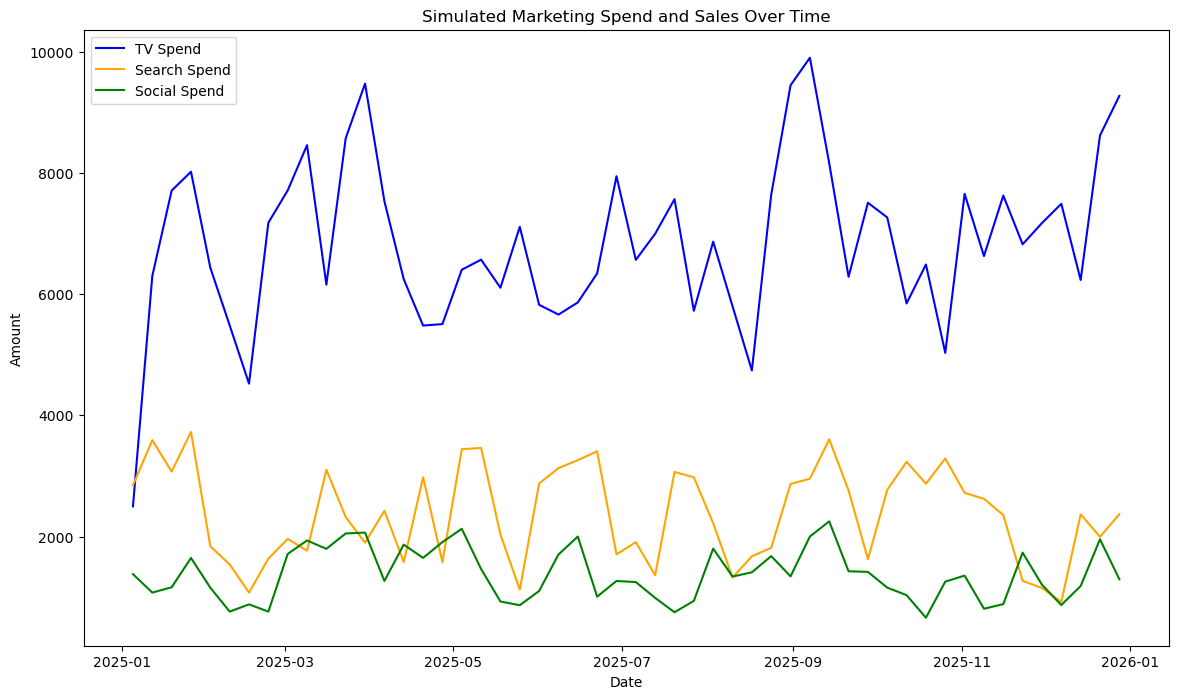

In [6]:
# visualize the data
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['tv_adstock'], label='TV Spend', color='blue')
plt.plot(data.index, data['search_adstock'], label='Search Spend', color='orange')
plt.plot(data.index, data['social_adstock'], label='Social Spend', color='green')
plt.title('Simulated Marketing Spend and Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

## 🧮 Step 3: Fit the Model

In [7]:
import statsmodels.api as sm

# Define X and y
X = data[['tv_spend', 'search_spend', 'social_spend']]
X = sm.add_constant(X)  # adds intercept
y = data['sales']

# Fit the model
model = sm.OLS(y, X).fit()

# View results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     4.246
Date:                Fri, 16 Jan 2026   Prob (F-statistic):            0.00969
Time:                        15:33:12   Log-Likelihood:                -346.40
No. Observations:                  52   AIC:                             700.8
Df Residuals:                      48   BIC:                             708.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           37.0198    105.195      0.352   

In [10]:
# roas proxy = coefficient x mean(transformed spend)
tv_coef = model.params['tv_spend']
tv_effect_mean = data['tv_spend'].mean()
tv_roas_proxy = tv_coef * tv_effect_mean
print(f"TV ROAS Proxy: {tv_roas_proxy:.2f}")

TV ROAS Proxy: 179.21


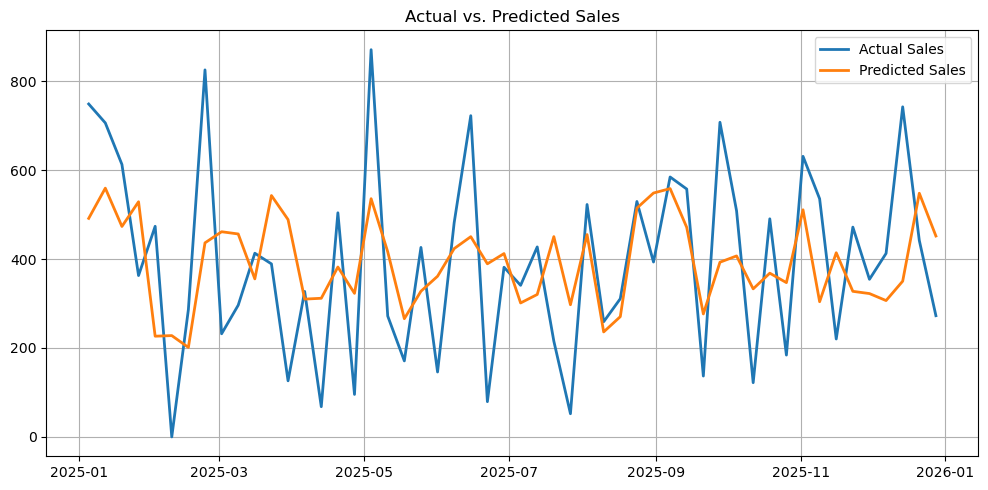

In [11]:
# Get predictions
data['predicted_sales'] = model.predict()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(data.index, data['sales'], label='Actual Sales', linewidth=2)
plt.plot(data.index, data['predicted_sales'], label='Predicted Sales', linewidth=2)
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
new_data = data.copy()
new_data['tv_spend_plus'] = new_data['tv_spend'] + 1000
X_plus = sm.add_constant(new_data[['tv_spend_plus','search_spend','social_spend']])
new_data['predicted_sales_plus'] = model.predict(X_plus)
new_data['sales_delta'] = new_data['predicted_sales_plus'] - new_data['predicted_sales']
print(f"Total lift from $1000 increase in TV spend: {new_data['sales_delta'].sum():.2f}")

Total lift from $1000 increase in TV spend: 3270.57


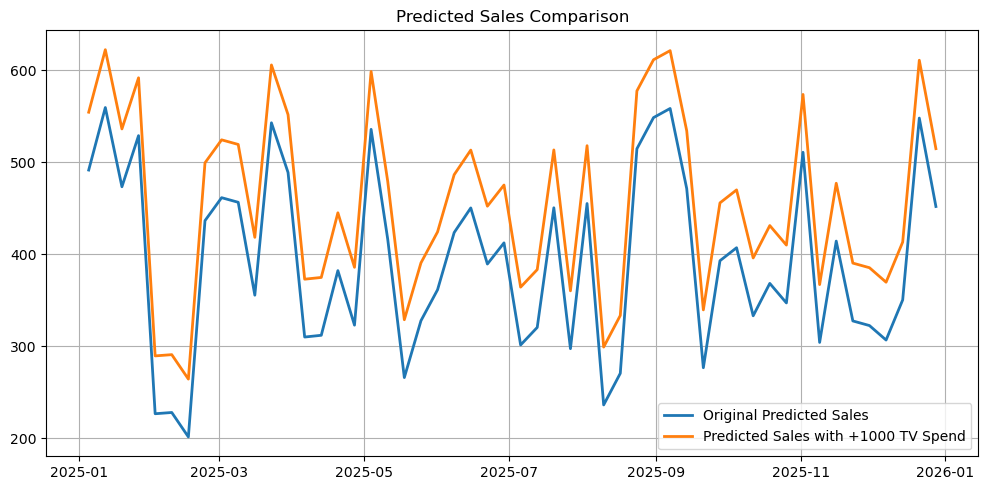

In [14]:
# Compare predicted sales with increased TV spend
plt.figure(figsize=(10, 5))
plt.plot(new_data.index, new_data['predicted_sales'], label='Original Predicted Sales', linewidth=2)
plt.plot(new_data.index, new_data['predicted_sales_plus'], label='Predicted Sales with +1000 TV Spend', linewidth=2)
plt.title('Predicted Sales Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 📊 Step 4: Interpret Results

- Adstock -> model carryover effects
- Saturation -> model diminishing returns
- Lagging -> model delayed effects

- For every 1 unit increase in tv spend, sales in creases by 0.0629 units (trickier to interpret when there is adstock, saturation, and lag effects)

## 🔁 Step 5: Write Takeaway

MMM can be a pretty basic model but things can get interesting when you add in transformation such as adstock and saturation effects.